In [ ]:
import pandas as pd
import numpy as np

from WindPy import *
w.start()

In [7]:
#Choose the preferred stocks to be allocated in the portfolio
stocklist=['ACN.N','TWTR.N','TSLA.O','AAPL.O','ATVI.O','AMZN.O','BAC.N','GE.N','F.N']
benchmark='SPX.GI'


In [14]:
import datetime
def database(codelist,Days,ret='0'):
    ##
    # if ret=0, return a time series#
    #if ret=1,return a return series#
    
    now = datetime.datetime.now()
    delta = datetime.timedelta(days=Days)
    old=now-delta
    a=now.strftime('%Y-%m-%d')
    b=old.strftime('%Y-%m-%d')
    data=pd.DataFrame()
    for i in codelist:
        data[i]=w.wsd(i,"close",b,a,"Period=M;Fill=Previous").Data[0]
    if ret=='0':           
        return data
    elif ret=='1':
        retu=pd.DataFrame()
        for j in range(len(code)):
            lis=[]
            for i in range(len(data)-1):
                lis.append((data.iloc[i+1,j]-data.iloc[i,j])/data.iloc[i,j])
            retu[code[j]]=lis
        return retu
    else:
        return "Invalid Input"

In [ ]:
# Wind database is too slow outside china, so decided to use existing data from excel
#return_matrix=pd.DataFrame()
#for i in stocklist:
#   return_matrix[i]=database(i,365*5)
#return_matrix

In [141]:
return_matrix=pd.read_csv('stocks.csv').iloc[:,2:]
benchmark_return=list(pd.read_csv('stocks.csv').iloc[:,1])
datelist=pd.read_csv('stocks.csv').iloc[:,0]

In [142]:
# start to build up function that automatically get the result of minimal variance allocation for each period
def get_mv(matrix):
    code=list(matrix.columns)
    cov_return=matrix.cov()
    cov_inv=pd.DataFrame(np.linalg.pinv(cov_return.values), cov_return.columns, cov_return.index)
    avg_return=np.array(matrix.mean())
    ones=np.ones(len(code))
    a=np.dot(np.dot(avg_return,cov_inv),avg_return.T)
    b=np.dot(np.dot(avg_return,cov_inv),ones)
    c=np.dot(np.dot(ones,cov_inv),ones)
    d=a*c-b**2
    weight_mv=np.dot(cov_inv,ones)/c
    port_return=b/c
    return [weight_mv,port_return]

In [143]:
#test the result of get_mv, and get the result correctly
get_mv(return_matrix) # checked with excel calculation

[array([ 0.03111691, -0.00354308,  0.15529541,  0.31012767, -0.02481981,
         0.31353447, -0.0667233 ,  0.1038715 ,  0.18114025]),
 0.004235034416438823]

In [144]:
#start to generate function to auto generate the moving tangency portfolio on a monthly basis

period=24 #back test period, set to 2 years
l=len(datelist)
result=np.array([1,1,1,1,1,1,1,1,1])
mean_result=[]
for i in range(l-period):
    weight=get_mv(return_matrix.iloc[i:i+period,:])[0]#get optimal weight for each backtest period
    hist_mean=get_mv(return_matrix.iloc[i:i+period,:])[1]
    result=np.vstack((result,weight))
    mean_result.append(hist_mean)
bt_result=pd.DataFrame(result[1:],index=datelist[period:],columns=list(return_matrix.columns))
bt_result['Expected Return']=mean_result
# start to deal with realized return
#realized return = weight * return matrix 
realized_return=[]

for i in range(l-period):
        realized_return.append(np.dot(np.array(bt_result.iloc[i,0:len(return_matrix.columns)]),
                                      np.array(return_matrix.iloc[period+i,0:len(return_matrix.columns)])))

bt_result['Realized Return']=realized_return
bt_result['Benchmark']=benchmark_return[period:]
bt_result.head()

,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Utilities,Expected Return,Realized Return,Benchmark
Date,,,,,,,,,,,,
2009/1/30,-0.046686,-0.144006,-0.088894,0.487399,-0.020774,0.431087,0.232698,0.064976,0.084199,-0.015495,-0.167474,-0.085657
2009/2/27,-0.033027,-0.082970,0.183144,0.311285,-0.068872,0.399313,0.018201,0.025207,0.247718,-0.010498,-0.137225,-0.109931
2009/3/31,0.009446,-0.059286,0.446363,0.247176,-0.060397,0.447082,-0.214656,0.114310,0.069960,-0.003160,0.015061,0.085405
2009/4/30,0.025776,-0.047983,0.423667,0.269820,-0.072693,0.472150,-0.184556,0.055748,0.058070,-0.004117,-0.093897,0.093925
2009/5/29,0.050176,0.093580,0.316365,0.314307,-0.085672,0.484921,-0.030017,-0.097539,-0.046120,-0.008842,0.101892,0.053081


In [146]:
#start to compare this portfolio with its benchmark
bt_result.iloc[:,-2:].describe()
#result indicates that the stocks picked are not very good

,Realized Return,Benchmark
count,132.000000,132.000000
mean,0.004202,0.010465
std,0.058429,0.039138
min,-0.407932,-0.109931
25%,-0.018692,-0.008998
50%,0.009986,0.016255
75%,0.035550,0.033682
max,0.101892,0.107723


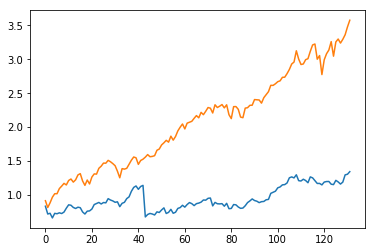

In [159]:
#plot a graph to show the performance of portfolio and benchmark
import matplotlib.pyplot as plt
#create a performance indicator line
RR=[]
BM=[]
ini=1
for i in bt_result.iloc[:,-2]:
    ini=ini*(1+i)
    RR.append(ini)
ini=1
for i in bt_result.iloc[:,-1]:
    ini=ini*(1+i)
    BM.append(ini)
plt.plot(RR)
plt.plot(BM)
#plt.xticks(np.arange(len(bt_result.iloc[:,0])),bt_result.iloc[:,0])

In [ ]:
# Conclusion:
# The stockes picked in this scenario, under minimal variance portfolio construction, is really a bad choice.